# Modelling and Evaluation Notebook

## Objectives

The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew

## Inputs

- inputs/datasets/cherry-leaves/test
- inputs/datasets/cherry-leaves/train
- inputs/datasets/cherry-leaves/validation
- image shape embeddings

## Outputs

- Images distribution plot in train, validation, and test set.
- Image augmentation.
- Class indices to change prediction inference in labels.
- Machine learning model creation and training.
- Save model.
- Learning curve plot for model performance.
- Model evaluation on pickle file.
- Prediction on the random image file.

---

## Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

### Set Working Directory


In [2]:
cwd= os.getcwd()
cwd

'/Users/simonpaske/Desktop/Project5-Mildew-Detection-in-Cherry-Leaves/jupyter_notebooks'

In [3]:
os.chdir('/Users/simonpaske/Desktop/Project5-Mildew-Detection-in-Cherry-Leaves/')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/Users/simonpaske/Desktop/Project5-Mildew-Detection-in-Cherry-Leaves'

---

### Set input directories

In [5]:
data_dir = 'inputs/datasets/cherry-leaves'
train_path = data_dir + '/train'
val_path = data_dir + '/validation'
test_path = data_dir + '/test'

print('Train path: ', train_path,'\n' 'Validation path: ', val_path,'\n' 'Test path: ', test_path)

Train path:  inputs/datasets/cherry-leaves/train 
Validation path:  inputs/datasets/cherry-leaves/validation 
Test path:  inputs/datasets/cherry-leaves/test


### Set output directory


In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set labels


In [7]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)

Project Labels: ['powdery_mildew', 'healthy']


### Set image shape

In [8]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(100, 100, 3)

---

## Number of images in train, test and validation dataset

Set: train, Label: powdery_mildew, Number of images: 1479
Set: train, Label: healthy, Number of images: 1466
Set: validation, Label: powdery_mildew, Number of images: 205
Set: validation, Label: healthy, Number of images: 215
Set: test, Label: powdery_mildew, Number of images: 420
Set: test, Label: healthy, Number of images: 423




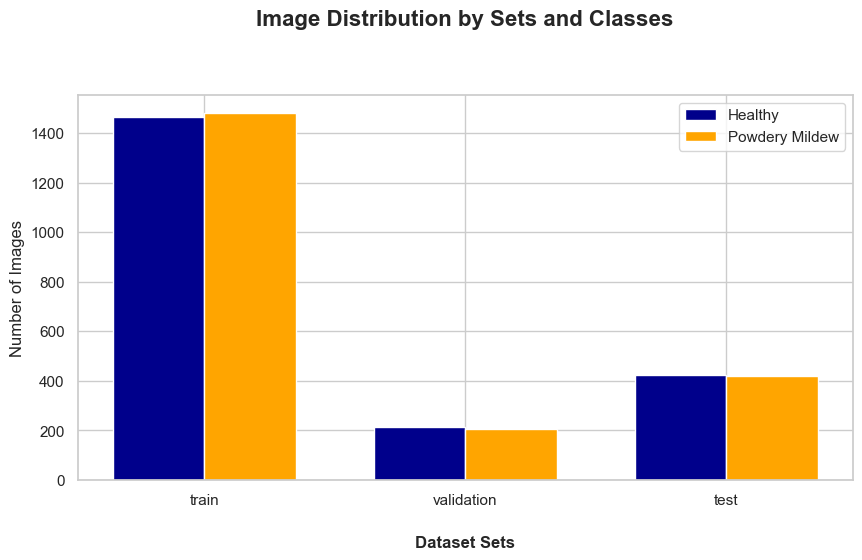

In [9]:
data_freq = []
for folder in ['train', 'validation', 'test']:
    for label in labels:
        path = os.path.join(data_dir, folder, label)
        data_freq.append(pd.DataFrame({'set': folder, 'label': label, 'count': [len(os.listdir(path))] }))
        print(f"Set: {folder}, Label: {label}, Number of images: {len(os.listdir(path))}")

# Concatenate the DataFrames
merged_data = pd.concat(data_freq)

# Create variables for plotting
index = np.arange(len(merged_data['set'].unique()))
sets = merged_data['set'].unique()
healthy_counts = merged_data[merged_data['label'] == 'healthy']['count']
mildew_counts = merged_data[merged_data['label'] == 'powdery_mildew']['count']

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
bar_width = 0.35

plt.bar(index, healthy_counts, bar_width, label='Healthy', color='darkblue')
plt.bar([i + bar_width for i in index], mildew_counts, bar_width, label='Powdery Mildew', color='orange')

plt.xlabel('Dataset Sets', labelpad=20, fontweight = 'bold')
plt.ylabel('Number of Images')
print('\n')
plt.title('Image Distribution by Sets and Classes', pad=50, fontsize=16, fontweight='bold')
plt.xticks([i + bar_width / 2 for i in index], sets) 
plt.legend()
plt.legend()
plt.show()


---

## Image data augmentation


#### ImageDataGenerator

In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

/Users/simonpaske/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Laad images from directory

In [11]:
def load_images(img_path, target_size=(100, 100), num_images=5):
    if os.path.isdir(img_path):
        img_filenames = os.listdir(img_path)[:num_images]
        img_paths = [os.path.join(img_path, img_filename) for img_filename in img_filenames]
        img_arrays = [image.img_to_array(image.load_img(path, target_size=target_size)) for path in img_paths]
        img_arrays = np.array(img_arrays)
        return img_arrays

#### Initialize ImageDataGenerator

In [54]:
def create_data_generator(directory, target_size=(100, 100), batch_size=32, class_mode='binary', shuffle=True):
    data_generator = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=(0.01, 0.5),
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        rescale=1./255,
        brightness_range=[0.5, 1.5],
        channel_shift_range=0.5,
        rotation_range=90,
        shear_range=0.1,
    )

    data_set = data_generator.flow_from_directory(
        directory,
        target_size=target_size,
        color_mode='rgb',
        batch_size=batch_size,
        class_mode=class_mode,
        shuffle=shuffle,
    )

    return data_set


In [55]:
train_set = create_data_generator(train_path, shuffle=True)

Found 2945 images belonging to 2 classes.


#### Augment validation image dataset

In [56]:
validation_set = create_data_generator(val_path, shuffle=False)


Found 420 images belonging to 2 classes.


#### Augment test image dataset

In [57]:
test_set = create_data_generator(test_path, shuffle=False)


Found 843 images belonging to 2 classes.


### Plot augmented training images

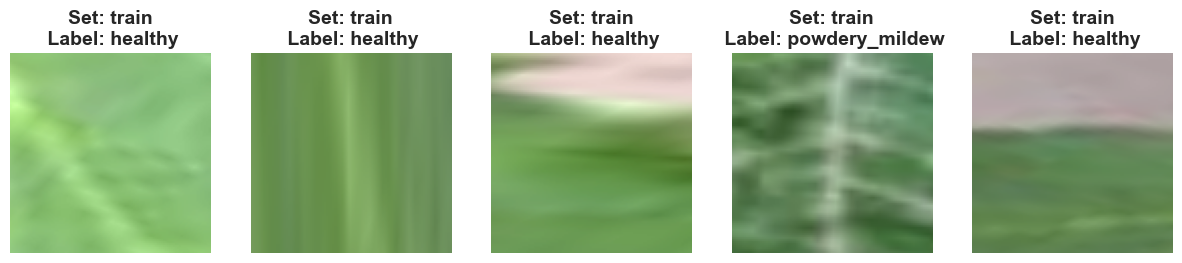

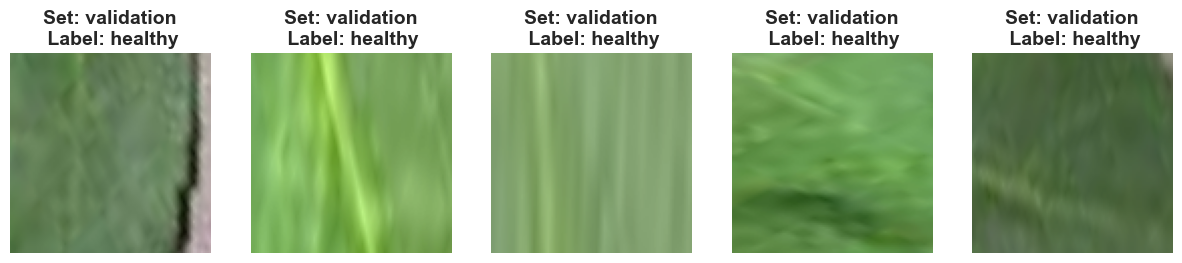

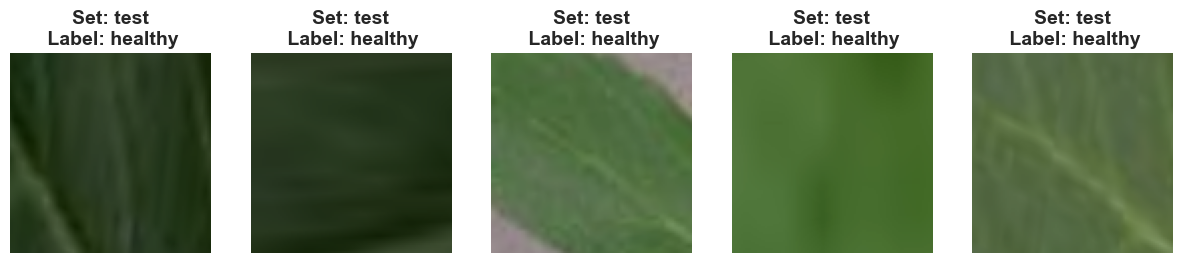

In [58]:
import matplotlib.pyplot as plt

def plot_images(data_generator, set_name):
    # Get a batch of images and labels
    images, labels = next(data_generator)

    # Map numerical labels to class names
    class_names = list(data_generator.class_indices.keys())

    # Get the class name for each label in the batch
    batch_class_names = [class_names[int(l)] for l in labels]

    # Plot the images
    plt.figure(figsize=(15, 3))
    for i in range(min(5, len(images))):  # Plot at most 5 images
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i])
        plt.title(f"Set: {set_name}\n Label: {batch_class_names[i]}", fontsize=14, fontweight='bold')
        plt.axis('off')
    plt.show()

# Assuming you have the data generators defined (train_set, validation_set, test_set)
# You can use the function to plot images from each set
plot_images(train_set, set_name='train')
plot_images(validation_set, set_name='validation')
plot_images(test_set, set_name='test')


#### Save class_indices


In [59]:

joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

## Model creation and training

### Import model packages

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
%pip install keras-tuner


### Create model

In [ ]:
def model(hp):
    model = Sequential()
    
    filters1 = hp.Int('filters1', min_value=32, max_value=640, step=32)
    kernel_size1 = hp.Int('kernel_size1', min_value=3, max_value=3)
    model.add(Conv2D(filters=filters1, kernel_size=(kernel_size1, kernel_size1), input_shape=(100, 100, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    filters2 = hp.Int('filters2', min_value=32, max_value=512, step=32)
    kernel_size2 = hp.Int('kernel_size2', min_value=3, max_value=3)
    model.add(Conv2D(filters=filters2, kernel_size=(kernel_size2, kernel_size2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    filters3 = hp.Int('filters3', min_value=32, max_value=512, step=32)
    kernel_size3 = hp.Int('kernel_size3', min_value=3, max_value=3)
    model.add(Conv2D(filters=filters3, kernel_size=(kernel_size3, kernel_size3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    
    filters4 = hp.Int('filters4', min_value=32, max_value=512, step=32)
    kernel_size4 = hp.Int('kernel_size4', min_value=3, max_value=3)
    model.add(Conv2D(filters=filters4, kernel_size=(kernel_size4, kernel_size4), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))  # Adjusted pool_size
    model.add(Dropout(0.1))
    
    model.add(Flatten())
    
    filters_dense = hp.Int('filters_dense', min_value=32, max_value=2560, step=32)
    model.add(Dense(filters_dense, activation='relu')) 
    model.add(Dropout(0.5))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


#### Optimizing Cherry Leaves Classification Model: A Hyperparameter Tuning Approach with Keras Tuner

In [ ]:

# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# RandomSearch Tuner
tuner_random = RandomSearch(
    model,
    objective='val_accuracy',
    max_trials=5,
    directory='keras_tuner_dir',
    project_name='random_search',
    metrics=['accuracy'],
    overwrite=True
)

# Hyperband Tuner
tuner_hyperband = Hyperband(
    model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='keras_tuner_dir',
    project_name='hyperband',
    metrics=['accuracy'],
    overwrite=True,
    executions_per_trial=5
)

# BayesianOptimization Tuner
tuner_bayesian = BayesianOptimization(
    model,
    objective='val_accuracy',
    max_trials=5,
    num_initial_points=3,
    directory='keras_tuner_dir',
    project_name='bayesian_optimization',
    overwrite=True
)

# Combine the tuners
combined_tuner = RandomSearch(
    model,
    objective='val_accuracy',
    max_trials=5,
    directory='keras_tuner_dir',
    project_name='combined_tuner',
    metrics=['accuracy'],
    overwrite=True
)

# Sequentially run the combined tuner
combined_tuner.search(train_set, epochs=5, validation_data=validation_set, callbacks=[early_stopping])


best_model = combined_tuner.hypermodel.build(best_trial_combined.hyperparameters)
best_model.summary()

# Save the best model's weights
best_model.save_weights('keras_tuner_dir/combined_tuner/best_model_weights')

# Compile the model
best_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)



#### Display model summary

In [ ]:

# Get the best trial from the combined tuner
best_trial_combined = combined_tuner.oracle.get_best_trials(1)[0]
print(best_trial_combined.values)

# Display information about the best trial
hyperparameters = best_trial_combined.hyperparameters.values
print(f"Best Trial ID: '\n'{best_trial_combined.trial_id}, '\n'Hyperparameters: '\n'{hyperparameters}")


#### Learning Curves for Cherry Leaves Classification

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'keras_tuner_dir/combined_tuner/best_model_weights',
    save_best_only=True,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)


# Train the best model and store the history
history = best_model.fit(train_set, epochs=5, validation_data=validation_set, callbacks=[early_stopping])

# Save the best model's weights
best_model.save_weights('keras_tuner_dir/combined_tuner/best_model_weights')

# Extract loss and accuracy from the training history
losses = pd.DataFrame(history.history)

# Plot training and validation losses
sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig('keras_tuner_dir/combined_tuner/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

# Plot training and validation accuracy
print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig('keras_tuner_dir/combined_tuner/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()